In [7]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from skspatial.objects import Points, Line

from tools.load_data import load_data
from tools.data_processing import pca, point_line_dist, e_radius, process_gravnet, get_clustering

In [2]:
#Data path and data containers
# file_pattern = "/home/nstrobbe/mahon336/hgcalmlSingularity/hgcal_minimal_eval_example/output/singlePhoton24-04-01/FTFP_BERT_EMN/*.pkl"
file_pattern = "/home/nstrobbe/mahon336/hgcalmlSingularity/hgcal_minimal_eval_example/output/singlePhoton24-04-01/nominal/*.pkl"
file_limit = 1000
files = glob.glob(file_pattern)[:file_limit]
data, score_noise_filter, pass_noise_filter, out_gravnet = [], [], [], []

#extract data, each length is {file_limit}
for file in tqdm(files):
    temp_load_data = load_data(file) #4 returns, all tensors
    data.append(temp_load_data[0])
    score_noise_filter.append(temp_load_data[1])
    pass_noise_filter.append(temp_load_data[2])
    out_gravnet.append(temp_load_data[3])

del temp_load_data, file, files, file_pattern

100%|██████████| 1000/1000 [00:06<00:00, 162.51it/s]


In [3]:
# Data processing - come get your variables
# Masks
true_cluster = np.array([ data[i].y for i in range(file_limit)], dtype=object) # real hits==1
final_pred_hits = np.array([ process_gravnet(score_noise_filter[i], pass_noise_filter[i], out_gravnet[i]) for i in range(file_limit)], dtype=object) #real clusterHits>0
# z positions
z_all = np.array([ data[i].x[:,7] for i in range(file_limit) ], dtype=object)
unique_z = np.sort(np.unique(np.round(np.concatenate(([np.unique(event) for event in z_all])))))
# true data
true_energy = np.array([ data[i].x[:,0][true_cluster[i]==1] for i in range(file_limit) ], dtype=object)
x_pos = np.array([ data[i].x[:,5][true_cluster[i]==1] for i in range(file_limit) ], dtype=object)
y_pos = np.array([ data[i].x[:,6][true_cluster[i]==1] for i in range(file_limit) ], dtype=object)
z_pos = np.array([ np.round(data[i].x[:,7][true_cluster[i]==1]) for i in range(file_limit) ], dtype=object)
# predicted data
pred_energy = np.array([ data[i].x[:,0][final_pred_hits[i] > 0] for i in range(file_limit) ], dtype=object)
x_pred= np.array([ data[i].x[:,5][final_pred_hits[i] > 0] for i in range(file_limit) ], dtype=object)
y_pred = np.array([ data[i].x[:,6][final_pred_hits[i] > 0] for i in range(file_limit) ], dtype=object)
z_pred = np.array([ np.round(data[i].x[:,7][final_pred_hits[i] > 0]) for i in range(file_limit) ], dtype=object)

del z_all, true_cluster, final_pred_hits, 


In [4]:
avg_wt_dists = []
absolute_distall = []
radius95 = []
radius68 = []
chi2 = []

avg_wt_dists_pred = []
absolute_distall_pred = []
radius95_pred = []
radius68_pred = []
chi2_pred = []

for event in tqdm(range(1000)):
    
    point, line = pca(x_pos[event], y_pos[event], z_pos[event])
    point_pred, line_pred = pca(x_pred[event], y_pred[event], z_pred[event])
    pees = np.array([x_pos[event], y_pos[event], z_pos[event]]).T
    pees_pred = np.array([x_pred[event], y_pred[event], z_pred[event]]).T
    total_energy = np.sum(np.array(true_energy[event]))
    total_energy_pred = np.sum(np.array(pred_energy[event]))
    absolute_dists = point_line_dist(pees,point,line)
    absolute_dists_pred = point_line_dist(pees_pred,point_pred,line_pred)
    absolute_distall.append(absolute_dists)
    absolute_distall_pred.append(absolute_dists_pred)
    
    #Chi2Calc
    chi2.append(sum(absolute_dists**2) / (len(true_energy[event]) - 4))
    chi2_pred.append(sum(absolute_dists_pred**2) / (len(pred_energy[event]) - 4))
    
    #RadiusCalc
    radius95.append(e_radius(absolute_dists, true_energy[event], 0.95))
    radius68.append(e_radius(absolute_dists, true_energy[event], 0.68))
    radius95_pred.append(e_radius(absolute_dists_pred, pred_energy[event], 0.95))
    radius68_pred.append(e_radius(absolute_dists_pred, pred_energy[event], 0.68))
    
    #SummedWeightedDistsGraph
    summed_ener_dists = sum(absolute_dists * np.array(true_energy[event]))
    summed_ener_dists_pred = sum(absolute_dists_pred * np.array(pred_energy[event]))
    summed_weighted_dists = summed_ener_dists/total_energy
    summed_weighted_dists_pred = summed_ener_dists_pred/total_energy_pred
    avg_wt_dists.append(summed_weighted_dists)
    avg_wt_dists_pred.append(summed_weighted_dists_pred)



100%|██████████| 1000/1000 [00:01<00:00, 766.86it/s]


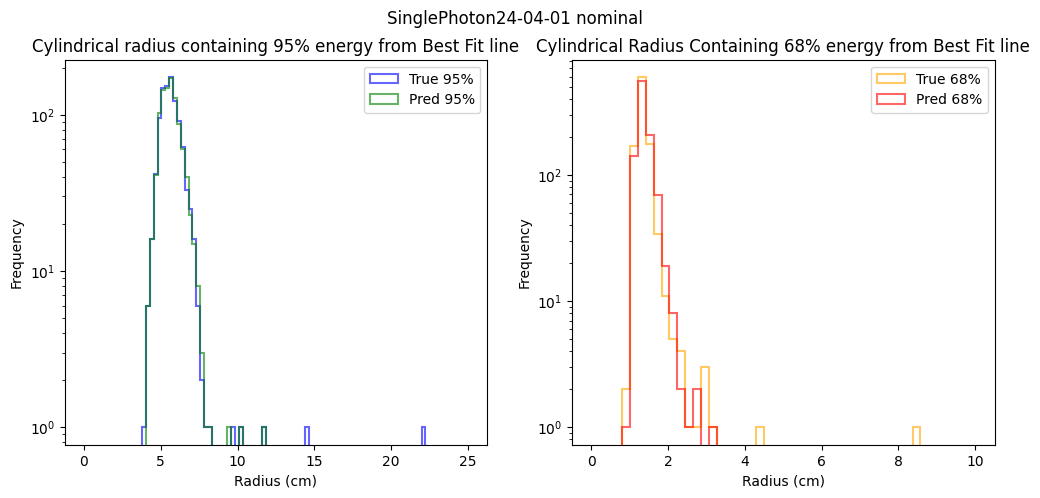

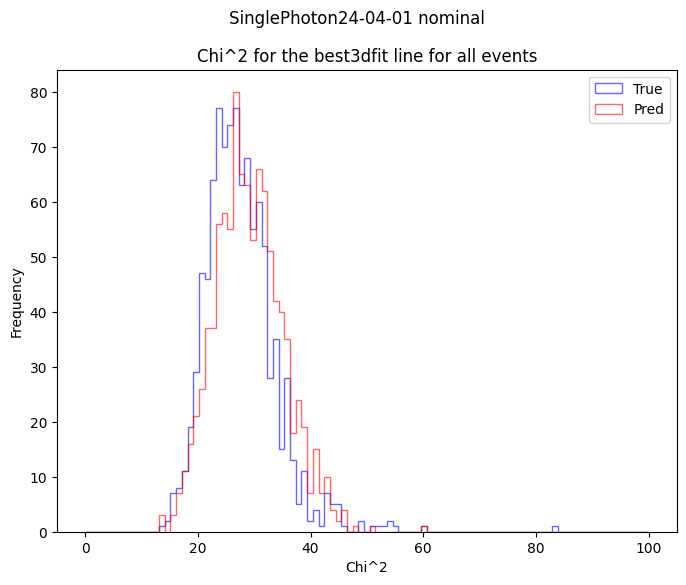

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(12)
fig.set_figheight(5)
fig.tight_layout
fig.suptitle("SinglePhoton24-04-01 nominal")
axs[0].hist(radius95, bins=np.linspace(0,25,25*4), linewidth=1.5, histtype='step', alpha=0.6, color="blue", label='True 95%')
axs[0].hist(radius95_pred, bins=np.linspace(0,25,25*4), linewidth=1.5, histtype='step', alpha=0.6, color="green", label='Pred 95%')
axs[1].hist(radius68, bins=np.linspace(0,10,10*5), linewidth=1.5, histtype='step', alpha=0.6, color="orange", label='True 68%')
axs[1].hist(radius68_pred, bins=np.linspace(0,10,10*5), linewidth=1.5, histtype='step', alpha=0.6, color="red", label='Pred 68%')

for ax in axs.flat:
    ax.set(ylabel="Frequency", yscale="log", xlabel="Radius (cm)")
    ax.legend()
axs[0].set_title(r"Cylindrical radius containing 95% energy from Best Fit line")
axs[1].set_title(r"Cylindrical Radius Containing 68% energy from Best Fit line")


plt.show()

fig, axs = plt.subplots(nrows=1, ncols=1)
fig.set_figwidth(8)
fig.set_figheight(6)
fig.tight_layout
fig.suptitle("SinglePhoton24-04-01 nominal")
axs.hist(chi2, bins=np.linspace(0,100,100), alpha=0.6, histtype='step', color='blue', label='True')
axs.hist(chi2_pred, bins=np.linspace(0,100,100), alpha=0.6, histtype='step', color='red', label='Pred')
axs.set_ylabel("Frequency")
# axs.set_yscale("log")
# axs.set_xscale("log")
axs.set_xlabel("Chi^2")
axs.set_title(r"Chi^2 for the best3dfit line for all events")
axs.legend()

plt.show()

In [ ]:
#Graveyard


# x_centered = []
# y_centered = []
# z_centered = []
# # We need the energy summed for each layer in case we need to weight the final line
# true_energy_summed = []
# for i in range(file_limit):
#     x_layer = []
#     y_layer = []
#     z_layer = []
#     true_energy_layer = []
#     for lz in unique_z:
#         try: 
#             x_layer.append( np.average(x_pos[i][z_pos[i]==lz], weights=true_energy[i][z_pos[i]==lz]) )
#             y_layer.append( np.average(y_pos[i][z_pos[i]==lz], weights=true_energy[i][z_pos[i]==lz]) )
#             z_layer.append(lz)
#             true_energy_layer.append( np.sum(np.array(true_energy[i][z_pos[i]==lz])) )
#         except:
#             pass
#     x_centered.append(x_layer)
#     y_centered.append(y_layer)
#     z_centered.append(z_layer)
#     true_energy_summed.append(true_energy_layer)
#     del x_layer, y_layer, z_layer, true_energy_layer


# event = 326

# trace0 = go.Scatter3d(
#     x = x_pos[event],
#     y = y_pos[event],
#     z = z_pos[event],
#     mode = "markers",
#     marker = {
#         "size":2,
#         "opacity":0.8,
#         # "color":"red"
#         "color":np.log(true_energy[event]),
#         "colorscale":"Inferno"
#     }
# )

# plot_figure = go.Figure()
# plot_figure.add_trace(trace0)

